#### Jeffrey Bradley, Taylor Tucker, Virginia Weston
#### Test 2
#### Prof. Watson
#### 10/20/2020

# Logistic Regression Analysis

Imports

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import scipy as sp
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import jaccard_score

Confusion matrix plot function used in previous work

In [54]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [55]:
df = pd.read_csv('CleanedData.csv')
df.drop(columns = "Unnamed: 0", inplace = True)
columns = df.columns
df

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,SES Percentage,Asian,african american,latinx,white,Chance of Admit
0,337.0,118.0,4,4.5,4.5,9.65,1,12,1,0,0,0,0.92
1,324.0,107.0,4,4.0,4.5,8.87,1,11,0,0,1,0,0.76
2,316.0,104.0,3,3.0,3.5,8.00,1,78,0,0,1,0,0.72
3,322.0,110.0,3,3.5,2.5,8.67,1,77,0,0,0,1,0.80
4,314.0,103.0,2,2.0,3.0,8.21,0,1,0,1,0,0,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,324.0,110.0,3,3.5,3.5,9.04,1,60,0,0,0,1,0.82
352,325.0,107.0,3,3.0,3.5,9.11,1,30,0,0,1,0,0.84
353,330.0,116.0,4,5.0,4.5,9.45,1,99,0,0,0,1,0.91
354,312.0,103.0,3,3.5,4.0,8.78,0,12,0,1,0,0,0.67


Similar to our decision trees method, Logistic Regression is binary classification so we will convert the Chance of admit to ones and zeros based on a threshold set by the median.

In [56]:
median_value = df["Chance of Admit"].median()
print(median_value)

0.73


Since the median chance of admission is 73%, I will use that as the threshold. Any chance of admission >= 0.73 will be
set to one, and any student < 0.73 will be set to 0

In [57]:
for i in range(len(df["Chance of Admit"])):
    if df.loc[i, "Chance of Admit"] >= 0.73:
        df.loc[i, "Chance of Admit"] = 1
    else:
        df.loc[i, "Chance of Admit"] = 0
print(df["Chance of Admit"])

0      1.0
1      1.0
2      0.0
3      1.0
4      0.0
      ... 
351    1.0
352    1.0
353    1.0
354    0.0
355    1.0
Name: Chance of Admit, Length: 356, dtype: float64


In [58]:
x = df.iloc[:,:12]
x

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,SES Percentage,Asian,african american,latinx,white
0,337.0,118.0,4,4.5,4.5,9.65,1,12,1,0,0,0
1,324.0,107.0,4,4.0,4.5,8.87,1,11,0,0,1,0
2,316.0,104.0,3,3.0,3.5,8.00,1,78,0,0,1,0
3,322.0,110.0,3,3.5,2.5,8.67,1,77,0,0,0,1
4,314.0,103.0,2,2.0,3.0,8.21,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
351,324.0,110.0,3,3.5,3.5,9.04,1,60,0,0,0,1
352,325.0,107.0,3,3.0,3.5,9.11,1,30,0,0,1,0
353,330.0,116.0,4,5.0,4.5,9.45,1,99,0,0,0,1
354,312.0,103.0,3,3.5,4.0,8.78,0,12,0,1,0,0


In [59]:
y = df['Chance of Admit']

#### Scale Data two different ways

StandardScaler()

In [60]:
x_SS = preprocessing.StandardScaler().fit_transform(x)

In [61]:
xSS_train, xSS_test, ySS_train, ySS_test = train_test_split(x_SS, y, test_size=0.3)

RobustScaler() to see if outliears are causing a problem

In [62]:
x_RS = preprocessing.RobustScaler().fit_transform(x)

In [63]:
xRS_train, xRS_test, yRS_train, yRS_test = train_test_split(x_RS, y, test_size=0.3)

### Logistic Regression with 'lbfgs' solver

#### StandardScaler

In [64]:
Log_Reg1 = LogisticRegression() #defaults to solver = 'lbfgs'
Log_Reg1.fit(xSS_train,ySS_train)
yhatSS = Log_Reg1.predict(xSS_test)
#yhatSS

In [65]:
Log_Loss = log_loss(ySS_test,yhatSS)
Log_Loss

5.164721681337872

The Jaccard Index compares the predicted binary results with the actual results, a score of 1.0 means every classification was correct while 0 means none were.

In [66]:
jaccard_score(ySS_test, yhatSS)

0.746031746031746

Confusion matrix, without normalization
[[47 10]
 [ 6 44]]


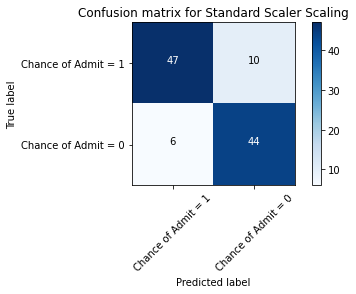

In [67]:
CM = confusion_matrix(ySS_test, yhatSS, labels=[1,0])
#np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(CM, classes=['Chance of Admit = 1','Chance of Admit = 0'],normalize= False,  title='Confusion matrix for Standard Scaler Scaling')

In [68]:
print (classification_report(ySS_test, yhatSS))

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.85        50
         1.0       0.89      0.82      0.85        57

    accuracy                           0.85       107
   macro avg       0.85      0.85      0.85       107
weighted avg       0.85      0.85      0.85       107



As you can see, the Logistic Regression performed decently well. It had a high jaccard score, low errors based on the confusion matrix, and 86% accuracy.

#### Now using RobustScaler()

In [69]:
Log_Reg2 = LogisticRegression() #defaults to solver = 'lbfgs'
Log_Reg2.fit(xRS_train,yRS_train)
yhatRS = Log_Reg2.predict(xRS_test)
#yhatSS

In [70]:
Log_Loss2 = log_loss(yRS_test,yhatRS)
Log_Loss2

3.8735375245668133

The Jaccard Index compares the predicted binary results with the actual results, a score of 1.0 means every classification was correct while 0 means none were.

In [71]:
jaccard_score(yRS_test, yhatRS)

0.8153846153846154

Confusion matrix, without normalization
[[53  8]
 [ 4 42]]


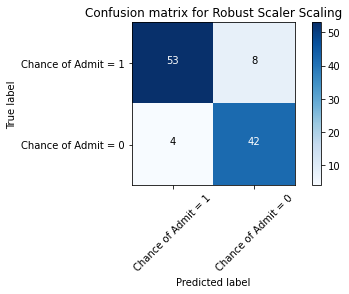

In [72]:
CM = confusion_matrix(yRS_test, yhatRS, labels=[1,0])
#np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(CM, classes=['Chance of Admit = 1','Chance of Admit = 0'],normalize= False,  title='Confusion matrix for Robust Scaler Scaling')

In [73]:
print (classification_report(yRS_test, yhatRS))

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87        46
         1.0       0.93      0.87      0.90        61

    accuracy                           0.89       107
   macro avg       0.88      0.89      0.89       107
weighted avg       0.89      0.89      0.89       107



The robust scaler method performed much better with a lower loss of 3.22, a jaccard index score of .80 and a better confusion matrix.

### Logistic Regression with 'liblinear' solver

#### StandardScaler

In [74]:
Log_Reg3 = LogisticRegression(solver = 'liblinear')
Log_Reg3.fit(xSS_train,ySS_train)
yhatSS = Log_Reg3.predict(xSS_test)
#yhatSS

In [75]:
Log_Loss = log_loss(ySS_test,yhatSS)
Log_Loss

5.164721681337872

The Jaccard Index compares the predicted binary results with the actual results, a score of 1.0 means every classification was correct while 0 means none were.

In [76]:
jaccard_score(ySS_test, yhatSS)

0.746031746031746

Confusion matrix, without normalization
[[47 10]
 [ 6 44]]


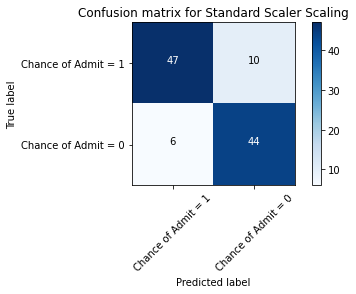

In [77]:
CM = confusion_matrix(ySS_test, yhatSS, labels=[1,0])
#np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(CM, classes=['Chance of Admit = 1','Chance of Admit = 0'],normalize= False,  title='Confusion matrix for Standard Scaler Scaling')

In [78]:
print (classification_report(ySS_test, yhatSS))

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.85        50
         1.0       0.89      0.82      0.85        57

    accuracy                           0.85       107
   macro avg       0.85      0.85      0.85       107
weighted avg       0.85      0.85      0.85       107



#### Now using RobustScaler()

In [79]:
Log_Reg2 = LogisticRegression(solver = 'liblinear') #defaults to solver = 'lbfgs'
Log_Reg2.fit(xRS_train,yRS_train)
yhatRS = Log_Reg2.predict(xRS_test)
#yhatSS

In [80]:
Log_Loss2 = log_loss(yRS_test,yhatRS)
Log_Loss2

3.8735375245668133

The Jaccard Index compares the predicted binary results with the actual results, a score of 1.0 means every classification was correct while 0 means none were.

In [81]:
jaccard_score(yRS_test, yhatRS)

0.8153846153846154

Confusion matrix, without normalization
[[53  8]
 [ 4 42]]


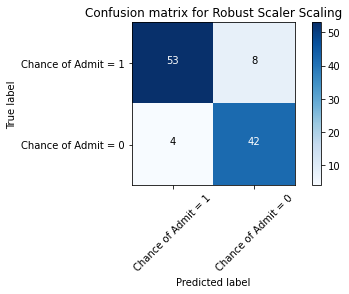

In [82]:
CM = confusion_matrix(yRS_test, yhatRS, labels=[1,0])
#np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(CM, classes=['Chance of Admit = 1','Chance of Admit = 0'],normalize= False,  title='Confusion matrix for Robust Scaler Scaling')

In [83]:
print (classification_report(yRS_test, yhatRS))

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87        46
         1.0       0.93      0.87      0.90        61

    accuracy                           0.89       107
   macro avg       0.88      0.89      0.89       107
weighted avg       0.89      0.89      0.89       107



The liblinear silver made absolutely no difference :/

### Conclusions

Overall logistic regression did a great job at classifying when a chance of admit would be over 0.73. The robust scaler, which helps with outliers, helped increase accuracy greatly. It can be assumed that outliers are present and could be throwing off other models. Our highest accuracy was found at 89% with robust scaler.